# generating influence diagrams, problem 1, iteration 1

## Background

the concepts in this iteration are based on literature:
From TNO report: guided root cause analysis of machine failures, author Emile van Gerwen
- modeling of systems is according to chapter 5

From Master thesis: sequential testing for the diagnosis of high-tech systems, author Joep Beurskens 
- modeling of decisions and tests is according to chapter 5
- deriving next best test is according to algorithm described in appendix C

Other concepts:
- the inference algorithm used is the inference build into the pyAgrum library, Shafer Shenoy LIMID Inference

## Definitions

a **system** is an assembly of components + connections between components

a **component** is defined by
- inputs and outputs. Both have associated modalities and a modality has properties.
- relations between inputs and outputs for normal behavior and for failure modes
- health node modelling if component is ok or in a failure mode
- a replace decision which is steered by a utility and influenced by the belief in health of a component
- the prior probabilities for components use zero or one as specified in literature

a **connection** is defined by
- two components that are connected via the connection
- a health node to model the health of the connection

an **assembly** is defined by
- components that are part of the assembly
- connections specifying how the components are connected
- tests to determine states and health of components or connections

**limitations/prerequisites** for this implementation:
- every component has one health and one output variable. multiple inputs are possible
- type names for components / connections are unique
- component / connection / variable names are unique and follow strict convention "PropertyModalityInputsName"

## Approach

steps to generate influence diagram from a system definition

implementation below uses following steps
- define system
  - define components (inputs/outputs, ...), connections, tests and assembly as python dictionaries

- read assembly, create objects
  - several classes model the system to facilitate the generation of a diagram

- create diagram 
  - turn component objects into diagram nodes + internal arcs, add to influence diagram
  - turn connection objects into diagram nodes, add arcs between components, add to influence diagram
  
- determine probabilities based on specified normal behavior, normal behavior is specified at component/connector level
- TODO add failure modes

- add replacement decisions for every component, utility uses costs
- TODO add replacement decisions for connections

- add tests to ID (only tests of health)
- TODO add cpt to test outcom

- TODO perform diagnosis scenario's
  - inference
  - decide best test

## System specification

### component specification

- a component has a unique type
- every component has one or more inputs, 
- every component has one output
- every component has one health
- every component has a decision when to replace the component
- inputs/outputs/health have modalities which have properties which have values

probabilities
- Health nodes don't have parents, priors can be determined beforehand and specified based on experience, data etc. A health node has a state for normal behavior and for every failure mode. The priors are part of the health node specification. 
- Input nodes don't have parents unless they are part of a connection, if so their cpt will be determined when the connection cpt's are determined
- A table specifies "normal behavior" via relations between input and output states. Since relations in components are deterministic (par 5.2.3) 0 and 1 are used. Note is that the "ALWAYS" and "ELSE" keywords are not yet used in the table.

decisions
- according to literature the replacement decision utility depends on:
  - Healthy + not replace     : 0
  - Healthy + replace         : replacement + incorrect replacement costs
  - not healthy + not replace : failure to repair
  - not healthy + replace     : replacement cost
- these costs are specified in the utility node connected to the replacement decision

In [3]:
import importlib

import printer_definition
# Make sure the actual file printer_definition.py is used by reloading the previously imported module.
importlib.reload(printer_definition)

import influence_diagram
# Make sure the actual file influence_diagram.py is used by reloading the previously imported module.
importlib.reload(influence_diagram)

<module 'influence_diagram' from 'C:\\Users\\kottev\\Documents\\PythonScripts\\jupyler\\contribution2\\influence_diagram.py'>

In [4]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Decisions":{
        "1":{
            "name":"Replace",
            "values":["yes", "no"],
            "replacementcosts": 2,
            "incorrectreplacementcosts": 3,
            "failuretorepaircosts": 4
            }
    },
    # normal behavior definition, example: all inputs:"yes" + output: "yes" + health:"ok" is a normal state (specified in "columns" below)
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no" , "no"], 
            'EnabledStateInputs':  ["yes", "no" ,"yes", "no"],
            'PresentPowerOutputs': ["yes", "no" ,"no" , "no"],
            'health':              ["ok",  "ok" , "ok", "ok"]
        }
    }
}

In [5]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Decisions":{
        "1":{
            "name":"Replace",
            "values":["yes", "no"],
            "replacementcosts": 2,
            "incorrectreplacementcosts": 3,
            "failuretorepaircosts": 4
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "no"], 
            'PresentLightOutputs': ["yes", "no"],
            'health':              ["ok",  "ok"]
        }
    }

}

### connections connect components 
- connections have a name and type
- connections have two typed components and a direction (start -> end)
- connections have a health that is connected to the component that is addressed by the connection: end
- a table specifies the relation between start and end component states considered normal
- health node has states for OK and for failure states



In [6]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light",
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs' :   ["yes"],
            'PresentPowerOutputs':   ["yes"],
            'health'             :   ["ok"]
        }
    }
}

wire2 = {
    "type":"Wire2",
    "start":"PresentLightOutputs",
    "typeStart":"Light",
    "end":"PresentPowerInputs",
    "typeEnd":"Switch",
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerOutputs':   ["yes"],
            'PresentPowerInputs' :   ["yes"],
            'health'             :   ["ok"]
        }
    }
}


### system structure defines assembly

- the structure defines what components are present in the system, what type they are and how they are named
- also specified are connections + which components a connection joins together

In [7]:
# small structure
structure1 = {
    "name":"structure1",
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

# bigger structure with more components and connections
structure3 = {
    "name":"structure3",
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        },
        "3":{
            "name":"Light1",
            "type":"Light"
        },
        "4":{
            "name":"Switch1",
            "type":"Switch"           
        },
        "5":{
            "name":"Light2",
            "type":"Light"
        },
        "6":{
            "name":"Switch2",
            "type":"Switch"           
        },
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        },
        "2":{
            "name":"Wire2",
            "type":"Wire2",
            "startComponent":"Light",
            "endComponent":"Switch1"
        },
        "3":{
            "name":"Wire3",
            "type":"Wire",
            "startComponent":"Switch1",
            "endComponent":"Light1"
        },
        "4":{
            "name":"Wire4",
            "type":"Wire2",
            "startComponent":"Light1",
            "endComponent":"Switch2"
        },
        "5":{
            "name":"Wire5",
            "type":"Wire",
            "startComponent":"Switch2",
            "endComponent":"Light2"
        }

    }
}


### test specification

tests used to test the health of a component are defined by
- a name for the test
- which component is tested
- nodes to generate:
  - a decision node to decide on if the test needs to be done or not
  - a utility node to steer the test decision based on the cost of the test
  - a node for the testoutcome + specification of it's outcomes and data to determine the prior probabilities
- a testmapping definition is used to bind a test to components

In [8]:
testObserveHealth = {
        "name":"TestObserveHealth",
        "typeUndertest":"Light",
        "decisionvalues":["yes", "no"],
        "testoutcomevalues":["ok","broken", "notdone"],
        "testcosts": -100,
        "testoutcomecpt":{
            'health':                    ["ok",     "broken" , "ok" ,"broken"],
            'DecisionTestObserveHealth': ["no",     "no"     , "yes","yes"   ],
            "TestObserveHealth":         ["notdone","notdone", "ok" ,'broken']
        }
    }

testmapping1 = {
    "1":{
        "test":"TestObserveHealth",
        "target":"Light"
    }
}


testmapping3 = {
    "1":{
        "test":"TestObserveHealth",
        "target":"Light"
    },
    "2":{
        "test":"TestObserveHealth",
        "target":"Light1"
    },
    "3":{
        "test":"TestObserveHealth",
        "target":"Light2"
    }
}

## imports

In [9]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re
import pandas as pd
from deepdiff import DeepDiff

## classes

- classes modelling components, connections, tests, assemblies to help generating a diagram
- these classes don't manipulate the influence diagram but do provide input to generate an influence diagram
- input to build the objects are the specifications for components, connections etc 

In [10]:
# this class models a component in the system
# the component is defined by it's name and specs (a dict)
# from the specs the internal variables are determined
class Component:
    def __init__(self, name, specs):
        self.name = name                                       # name of the component
        self.specs = specs                                     # dict specifying component
        self.variables = []                                    # Labelized variables used to generate nodes in diagram
        self.internalconnections = []                          # arcs between inputs > output + healt > output
        self.cptoutput = {}                                    # specification of cpt for outputnode
        self.replacedecision = {}                              # dict specifying nodes necessary to model replace decision
        self.setVariables()                           
        self.setInternalConnections()
        self.setCptOutput()
        self.setReplaceDecision()

    # create pyAgrum Labelized variables per node in the component
    def setVariables(self):
        v = self.specs["Outputs"]["1"]
        varname = str( v['property'] + v['modality']+ "Outputs" + self.name)
        self.variables.append(gum.LabelizedVariable(varname, varname, v['propertyvalues'])) 
        for k, v in self.specs["Inputs"].items():
            varname = str( v['property'] + v['modality']+ "Inputs" + self.name)
            self.variables.append(gum.LabelizedVariable(varname, varname, v['propertyvalues']))            
        v = self.specs["Healths"]["1"]
        varname = str(v["property"] + self.name)
        self.variables.append(gum.LabelizedVariable(varname, varname, v['propertyvalues']))

    # define the connections that are internal to the component
    def setInternalConnections(self):
        # define connections for inputs / health nodes to output within component
        for variable in self.variables:
            if(re.search("Outputs", variable.name())):
                outputname = variable.name()
        for variable in self.variables:
            if(re.search("Inputs", variable.name())):
                self.internalconnections.append((variable.name(), outputname))
            elif(re.search("health", variable.name())):
                self.internalconnections.append((variable.name(), outputname))
    
    # read the normal behavior table, store in format that can be used later
    def setCptOutput(self):
            dfstates = pd.DataFrame.from_dict(data = self.specs['Behavior']['normal'])
            dfstates.rename(columns=lambda x: x + self.name, inplace=True)
            # transform dataframe back to dict but in different format for comparison
            self.cptoutput = dfstates.to_dict('index')
            
    # create dict with specification of a replace decision
    def setReplaceDecision(self):
        for k, decision in self.specs["Decisions"].items():
            if (re.search("Replace", decision["name"])):
                decisionvarname = "Decision" + decision["name"] + self.name
                utilityvarname = "Utility" + decision["name"] + self.name
                self.replacedecision["decision"] = gum.LabelizedVariable(decisionvarname, decisionvarname, decision['values'])
                self.replacedecision["utility"] = gum.LabelizedVariable(utilityvarname, utilityvarname, 1)
                self.replacedecision["arcs"] = [(decisionvarname, utilityvarname),(self.getHealthVarName(), utilityvarname)]
                self.replacedecision["replacementcosts"] = decision["replacementcosts"]
                self.replacedecision["incorrectreplacementcosts"] = decision["incorrectreplacementcosts"]
                self.replacedecision["failuretorepaircosts"] = decision["failuretorepaircosts"]


# get methods
    def getComponentNodeNames(self):
        varlist = []
        for var in self.variables:
            varlist.append(var.name())
        return varlist
    def getName(self):
        return self.name
    def getVariables(self):
        return self.variables
    def getInternalConnections(self):
        return self.internalconnections
    def getCptOutput(self):
        return self.cptoutput
    def getHealthVarName(self):
        for name in self.getComponentNodeNames():
            if (re.search("health", name)):
                return name
    def getHealthPrior(self):
        v = self.specs["Healths"]["1"]
        return v["priorprobability"]
    def getOutputsVarName(self):
        for name in self.getComponentNodeNames():
            if (re.search("Outputs", name)):
                return name
    def getInputsVarNames(self):
        nodenames = []
        for name in self.getComponentNodeNames():
            if (re.search("Inputs", name)):
                nodenames.append(name)
        return nodenames
    def getInputPrior(self, inputitem):
        for k, v in self.specs["Inputs"].items():
            varname = str( v['property'] + v['modality']+ "Inputs" + self.name)
            if (varname == inputitem):
                return v["priorprobability"]
    def getReplaceDecision(self):
        return self.replacedecision

In [11]:
# class Connection models connections between component in the system
# a connection is defined by it's name, specs (dict) and start + end components

class Connection:
    def __init__(self, name, specs, startnode, endnode):
        self.name = name                                     # name of the connection
        self.specs = specs                                   # dict specifying properties of connection
        self.startnode = startnode                           # name of variable starting point for connection
        self.endnode = endnode                               # name of variable ending point for connection
        self.cptendcomponent = self.setCptEndComponent()     # storing normal behavior table
        
    # create pyAgrum labelized variable used when adding health for connection to diagram
    def getHealthVariable(self):
        label = "health" + self.name
        v = self.specs["Healths"]["1"]
        propertyvalues = v["propertyvalues"]
        return gum.LabelizedVariable(label, label, propertyvalues)
    
    # determine start / end component names
    def addComponentName(self, name):
        if (re.search(name, self.startnode)): return self.startnode
        elif (re.search(name, self.endnode)): return self.endnode
        elif (re.search("health", name)): return name + self.name
        
    # prepare normal behavior table for later use determining cpt of endcomponent
    def setCptEndComponent(self):
        dfstates = pd.DataFrame.from_dict(data = self.specs['Behavior']['normal'])
        dfstates.rename(columns=lambda x: self.addComponentName(x), inplace=True)
        # transform dataframe back to dict but in different format for comparison
        return dfstates.to_dict('index')

    # get methods
    def getStartNode(self):
        return self.startnode
    def getEndNode(self):
        return self.endnode
    def getCptEndComponent(self):
        return self.cptendcomponent
    def getHealthPrior(self):
        v = self.specs["Healths"]["1"]
        return v["priorprobability"]
    def getName(self):
        return self.name
        

In [12]:
# class test models an observation test
# test is defined by it's name, the target component (healthnode) and a dict containing specs

class Test:
    def __init__(self, name, target, specs):
        self.name = name
        self.specs = specs
        self.target = target
        self.decisionvalues = self.specs["decisionvalues"]
        self.testoutcomevalues = self.specs["testoutcomevalues"]
        self.testoutcomecpt = self.specs["testoutcomecpt"]
        self.testcosts = self.specs["testcosts"]
    def getName(self):
        return self.name
    def getTarget(self):
        return self.target
    def getDecisionValues(self):
        return self.decisionvalues 
    def getTestOutcomeValues(self):
        return self.testoutcomevalues
    def getTestOutcomeCpt(self):
        return self.testoutcomecpt
    def getTestCosts(self):
        return self.testcosts   

In [13]:
# class assembly contains objects for all part of the system: components, connections, tests

class Assembly:
    def __init__(self, name, components, connections, tests):
        self.name = name
        self.components = components
        self.connections = connections
        self.tests = tests
    def getComponents(self):
        return self.components
    def getConnections(self):
        return self.connections
    def getTests(self):
        return self.tests

## composing system

- turning the specifications into objects helps to generate the diagram lateron

In [14]:
# helper to find a specification that matches a given type
def getTypeSpecs(specs, ctype):
    for c in specs:
        if (c["type"] == ctype):
            return c

# helper to find a specific component by name in list of components
def findComponent(requestedcomponent, componentlist):
    for component in componentlist:
        if (component.getName() == requestedcomponent):
            return component

# helper to determine start / end nodes based on list of existing components and connection specs
def determineConnectionStartEndNodes(connection, componentslist, specs):
    # determine startComponent: variablename
    startcomponentobject = findComponent(connection["startComponent"], componentslist)
    endcomponentobject = findComponent(connection["endComponent"], componentslist)
    for label in startcomponentobject.getVariables():
        if(re.search(specs["start"], label.name())):
            startname = label.name()
    for label in endcomponentobject.getVariables():
        if(re.search(specs["end"], label.name())):
            endname = label.name()
    return (startname, endname)

    
# create components objects
# loop structure, find specs, create component object
def getComponents(assembly):
    componentObjects = []
    for k, component in assembly["structure"]["components"].items():
        specs = getTypeSpecs(assembly["components"], component['type'])
        componentObjects.append(Component(component["name"], specs))
    return componentObjects
    

# create connections objects
# loop connections in structure, find specs and start/end components,  create connection object
def getConnections(assembly, componentslist):
    connectionObjects = []
    for k, conn in assembly["structure"]["connections"].items():
        print(assembly["connections"])
        specs = getTypeSpecs(assembly["connections"], conn["type"])
        startendnames = determineConnectionStartEndNodes(conn, componentslist, specs)
        connectionObjects.append(Connection(conn["name"], specs,startendnames[0],startendnames[1]))
    return connectionObjects


# create Test objects
# loop the testmapping specification, find test specs + targetnode, create testobject
def getTests(assembly, componentslist):
    testObjects = []
    for k, test in assembly['testmapping'].items():
        for testtype in assembly["tests"]:
            if (test["test"] == testtype["name"]):
                specs = testtype
                testObjects.append(Test(testtype['name'], test["target"], specs))
    print(testObjects)
    return testObjects
        
    
# MAIN method to build objects and create a system definition
def readAssembly(assembly):
    name = assembly['structure']["name"]
    print("building system: " + name)

    componentslist = getComponents(assembly)
    print("number of components: " + str(len(componentslist)))

    connectionslist = getConnections(assembly, componentslist)
    print("number of connections: " + str(len(componentslist)))

    testslist = getTests(assembly, componentslist)
    print("number of tests: " + str(len(testslist)))
    
    return Assembly(name, componentslist, connectionslist, testslist)

## generate influence diagram structure

- add components to diagram
- add connections to diagram

In [15]:
# loop components that are part of the system
# get the variables representing inputs, outputs, health and add to diagram
# add internal components arcs inputs > output + health > output
def addBNNodesToDiagram(diagram, system):
    for component in system.getComponents():
        print("adding component: " + component.getName())
        variables = component.getVariables()
        for item in variables:
            diagram.addChanceNode(item)
        for connection in component.getInternalConnections():
            diagram.addArc(connection[0], connection[1])

In [16]:
# loop connections that are part of the system
# determine start / end components, add arc between them
# add health to end component
def addComponentConnectionsToDiagram(diagram, system):
    for connection in system.getConnections():
        hid = diagram.addChanceNode(connection.getHealthVariable())
        start = connection.getStartNode()
        end = connection.getEndNode()
        print("adding connection between: " + start + " and: " + end)
        diagram.addArc(start, end)
        diagram.addArc(hid, diagram.idFromName(end))


## determine prior probabilities

### approach to determine probabilities differs per type of node + components vs connections

Health en Inputs
- healths have a normal state and a state for each failure mode, priors can be placed in specification since there is no parent
- inputs have "operational" states (PresentPower yes/no), priors are deterministic and specified via 1 / 0 in the component specification 

Outputs
- the normal state (relations between states of components) is specified as a table in the component specification
- due to deterministic relations 0 and 1 can be used

connecties
- connections are treated as a "component": a table in the connection specification can define "normal behavior and health node can follow guidelines for health of a component 

### implementation

- step 1: prior per component 
  - loop components, determine health, input and outputnodes
  - validate inputs and healths have no parent
  - fill priors for input and health from specifications
    - prior for health is 1 - sum of failture modes
    - inputs: prior is 1 for "normal operational state"
      - inputs that have parents are parked for later as they are part of a connection
    - outputs: check all tuples of states in cpt and check if they exsist in normal state relation table    

- step 2: prior per connection
  - loop connections
  - startcomponents should already have priors set and don't need changing
  - for endcomponent read normal behavior relation table from connection specification, follow output method
  - for health follow component health approach

In [17]:
# determine probabilities (CPT) for variables of a component

def hasParent(diagram, variableName):
    
    variableId = diagram.idFromName(variableName)
    
    for a in diagram.arcs():
        if (a[1] == variableId): return True
    return False          
           
                
def setProbabilitiesComponents(diagram, system):

    # loop components, determine nodes
    for component in system.getComponents():
        print("adding cpt for component: " + component.getName())
        health = component.getHealthVarName()
        inputs = component.getInputsVarNames()
        output = component.getOutputsVarName()
        
        # check there are no parents, fill cpt from specs
        if (not hasParent(diagram, health)):        
            diagram.cpt(diagram.idFromName(health)).fillWith(component.getHealthPrior())
            
        for inputnode in inputs:
            if (not hasParent(diagram, inputnode)):
                diagram.cpt(diagram.idFromName(inputnode)).fillWith(component.getInputPrior(inputnode))

        # CPT has type Potential and contains tuples (Instantiations) of discrete variables
        # loop in CPT, transform tuple to dict
        # if tuple is in normal behavior table: set P(1), else 0
        for tupleVars in diagram.cpt(diagram.idFromName(output)).loopIn():
            t1 = tupleVars.todict()
            for k, s in component.getCptOutput().items():
                if ('values_changed' not in DeepDiff(s, t1).keys()):
                    diagram.cpt(diagram.idFromName(output)).set(tupleVars, 1)
            
        for tupleVars in diagram.cpt(diagram.idFromName(output)).loopIn():
            row = tupleVars.todict()
            if (influence_diagram.get_value_health_variable(row) == 'broken' and influence_diagram.get_value_output_variable(row) == 'no'):
                diagram.cpt(diagram.idFromName(output)).set(tupleVars, 1)
            

In [18]:
t1 = {'PresentLaserBeamOutputsLaserDiode': 'yes', 'PresentPowerInputsLaserDiode': 'yes', 'healthLaserDiode': 'ok'}

for key in t1:
    if 'Outputs' in key:
        print(t1[key])

print(influence_diagram.get_value_output_variable(t1))


yes
yes


In [19]:
# determine probabilities (CPT) for variables of a connection

def setProbabilitiesConnections(diagram, system):

    # loop connections, get endnode and normal behavior table
    for connection in system.getConnections():
        print("adding cpt for connection: " + connection.getName())
        endnode = connection.getEndNode()
        normalbehaviortable = connection.getCptEndComponent()

        # loop cpt and check if state is known as normal behavior
        for tupleVars in diagram.cpt(diagram.idFromName(endnode)).loopIn():
            t1 = tupleVars.todict()
            for k, s in normalbehaviortable.items():
                if ('values_changed' not in DeepDiff(s, t1).keys()):
                    diagram.cpt(diagram.idFromName(endnode)).set(tupleVars, 1)  

        for tupleVars in diagram.cpt(diagram.idFromName(endnode)).loopIn():
            row = tupleVars.todict()
            if (influence_diagram.get_value_health_variable(row) == 'broken' and influence_diagram.get_value_input_variable(row) == 'no'):
                diagram.cpt(diagram.idFromName(endnode)).set(tupleVars, 1)            
                    
        # set cpt for health
        did = diagram.idFromName(connection.getHealthVariable().name())
        diagram.cpt(did).fillWith(connection.getHealthPrior())    

## replace decisions for components

A replace decision is modelled by:
- decision
- utility. 

arcs: 
- health > utility
- decision > utility

In [20]:
# add decision to replace component for every component that is part of the structure
def addReplaceDecisions(diagram, system):

    for component in system.getComponents():
        print("adding Replace decision for component: " + component.getName())
        healthnodename = component.getHealthVarName()
        decision = component.getReplaceDecision()
        diagram.addDecisionNode(decision["decision"])
        diagram.addUtilityNode(decision["utility"])
        for arc in decision["arcs"]:
            diagram.addArc(arc[0], arc[1])

utility values are calculated via following formula

- Healthy + not replace     : 0
- Healthy + replace         : replacement + incorrect replacement costs
- not healthy + not replace : failure to repair
- not healthy + replace     : replacement cost

values for costs are gathered from component specifications

In [21]:
# given costs calculate utility per row in utility table

def calculateReplaceUtility(diagram, diagramNodeIndex, utilitytable, replacementcosts, incorrectreplacementcosts, failuretorepaircosts):
    for t in utilitytable.loopIn():
        utilitycosts = 0
        healthy = None
        replace = None
        utilityrow = t.todict()

        # loop in utility table, determine state for health or repair
        for k, row in utilityrow.items():
            if(re.search("health", k)):
                if (row == "ok"): healthy = True
                else:             healthy = False
            elif(re.search("Replace", k)):
                if (row == "yes"): replace = True
                else:              replace = False
    
        if (healthy != None or repair != None ):
            if (healthy and replace): 
                utilitycosts = -replacementcosts - incorrectreplacementcosts
            elif(not healthy and replace):
                utilitycosts = -replacementcosts 
            elif(not healthy and not replace):
                utilitycosts = -failuretorepaircosts
        diagram.utility(diagramNodeIndex)[utilityrow] = utilitycosts

In [22]:
# loop components, get costs, calculate utility
def fillReplaceDecisionUtilities(diagram, system):
    
    for component in system.getComponents():
        print("adding Replace utility for component: " + component.getName())

        # get the decision and costs
        decision = component.getReplaceDecision()
        replacementcost = decision["replacementcosts"]
        incorrectreplacementcosts = decision["incorrectreplacementcosts"]
        failuretorepaircosts = decision["failuretorepaircosts"]

        # calculate utility based on costs and paste into utility table
        did = diagram.idFromName(decision["utility"].name())
        calculateReplaceUtility(diagram, did, diagram.utility(did), replacementcost, incorrectreplacementcosts, failuretorepaircosts)

## add observation tests


types of tests:
- observations
- different inputs
- replace a part
- manipulate state

assumptions: 
- tests are perfect > CPT uses 0's and 1's

type of obervations:
- testing health of component/connection
- checking state of component, evidence gathering


testing health of component is only version of tests implemented at the moment

In [23]:
def addTests(diagram, system):
    
    for test in system.getTests():
        print("adding test: " + test.getName() + " to component: " + test.getTarget())
        
        # names for nodes
        decisionNodeLabel = "Decision" + test.getName() + test.getTarget()
        utilityNodeLabel = "Utility" + test.getName() + test.getTarget()
        testoutcomeNodeLabel = "TestOutcome" + test.getName() + test.getTarget()

        # add Node for Decision
        decisionNodeId = diagram.addDecisionNode(gum.LabelizedVariable(decisionNodeLabel,decisionNodeLabel,test.getDecisionValues()))

        # add Node for utility + arc D > U
        utilityNodeId = diagram.addUtilityNode(gum.LabelizedVariable(utilityNodeLabel, utilityNodeLabel, 1))

        
        diagram.addArc(decisionNodeId, utilityNodeId)
        diagram.utility(utilityNodeId)[{decisionNodeLabel:"yes"}]=test.getTestCosts()
            
        # add Node for test outcome + arc D + Health > TO
        testoutcomeNodeId = diagram.addChanceNode(gum.LabelizedVariable(testoutcomeNodeLabel, testoutcomeNodeLabel, test.getTestOutcomeValues()))
        diagram.addArc(decisionNodeId, testoutcomeNodeId)
    
        # add arc from health > testoutcome
        diagram.addArc(diagram.idFromName("health" + test.getTarget()), testoutcomeNodeId)
               
        for tupleVars in diagram.cpt(testoutcomeNodeId).loopIn():
            row = tupleVars.todict()
            if (influence_diagram.get_value_decision_test_variable(row) == 'no' and influence_diagram.get_value_test_outcome_variable(row) == 'notdone'):
                diagram.cpt(testoutcomeNodeId).set(tupleVars, 1) 
            
            if (influence_diagram.get_value_decision_test_variable(row) == 'yes' and influence_diagram.get_value_health_variable(row) == 'ok' and influence_diagram.get_value_test_outcome_variable(row) == 'ok'):
                diagram.cpt(testoutcomeNodeId).set(tupleVars, 1)
                
            if (influence_diagram.get_value_decision_test_variable(row) == 'yes' and influence_diagram.get_value_health_variable(row) == 'broken' and influence_diagram.get_value_test_outcome_variable(row) == 'broken'):
                diagram.cpt(testoutcomeNodeId).set(tupleVars, 1)                
            
        


## visualize structure

In [24]:
from IPython.display import display, HTML

def visualizeStructure(diagram):
    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=15)

## visualize cpts

In [25]:
def showCPTs(diagram, system):
    for component in system.getComponents():
        vars = component.getVariables()
        for v in vars:
            gnb.flow.row(diagram.cpt(v.name()))   
#    for i in range(0, diagram.size()-1):
#        gnb.flow.row(diagram.cpt(i))
        

In [26]:
def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

In [27]:
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))





In [28]:
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

In [29]:
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))



# main method

building system: structure_laserprinter
number of components: 3
[{'type': 'Beam1', 'start': 'PresentLaserBeamOutputs', 'typeStart': 'LaserDiode', 'end': 'PresentLaserBeamInputs', 'typeEnd': 'Mirror6Sided', 'Healths': {'1': {'modality': 'Health', 'property': 'health', 'propertyvalues': ['ok', 'broken'], 'priorprobability': [0.9, 0.1]}}, 'Behavior': {'normal': {'PresentLaserBeamOutputs': ['yes', 'no'], 'PresentLaserBeamInputs': ['yes', 'no'], 'health': ['ok', 'ok']}}}, {'type': 'Beam2', 'start': 'PresentLaserBeamOutputs', 'typeStart': 'Mirror6Sided', 'end': 'PresentLaserBeamInputs', 'typeEnd': 'AcrylicLens', 'Healths': {'1': {'modality': 'Health', 'property': 'health', 'propertyvalues': ['ok', 'broken'], 'priorprobability': [0.9, 0.1]}}, 'Behavior': {'normal': {'PresentLaserBeamOutputs': ['yes', 'no'], 'PresentLaserBeamInputs': ['yes', 'no'], 'health': ['ok', 'ok']}}}]
[{'type': 'Beam1', 'start': 'PresentLaserBeamOutputs', 'typeStart': 'LaserDiode', 'end': 'PresentLaserBeamInputs', 'type

Influence Diagram{
  chance: 12,
  utility: 4,
  decision: 4,
  arcs: 19,
  domainSize: 98304
}


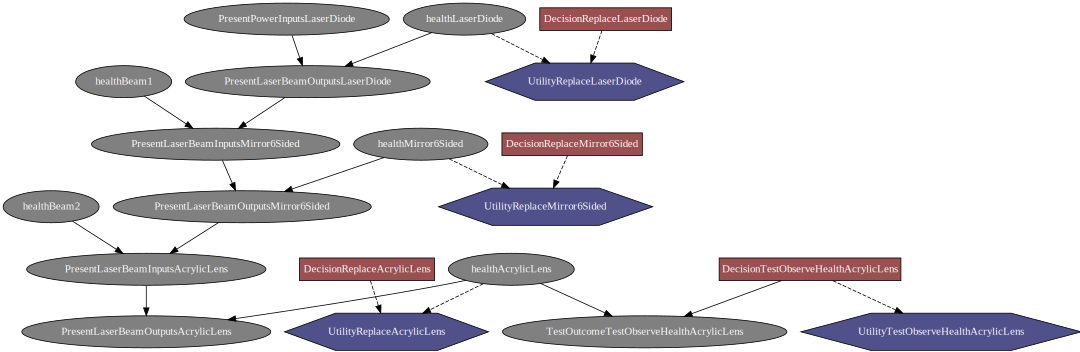

CPT tables for component: LaserDiode


CPT tables for component: Mirror6Sided


CPT tables for component: AcrylicLens


Utility tables for component: LaserDiode


Utility tables for component: Mirror6Sided


Utility tables for component: AcrylicLens


In [30]:
# create assembly containing components, connections and structure
components  = [printer_definition.laser_diode, printer_definition.mirror_6_sided, printer_definition.acrylic_lens]
connections = [printer_definition.beam1, printer_definition.beam2]
tests = [testObserveHealth]
assembly = {
    "components" : components,
    "connections": connections,
    "structure"  : printer_definition.structure_laserprinter,
    "tests"      : tests,
    "testmapping": printer_definition.testmapping3
}
# read assembly
system = readAssembly(assembly)

# create diagram
diagram = gum.InfluenceDiagram()

# add Bayes Network structure to diagram
addBNNodesToDiagram(diagram, system)

addComponentConnectionsToDiagram(diagram, system)

setProbabilitiesComponents(diagram, system)

setProbabilitiesConnections(diagram, system)

addReplaceDecisions(diagram, system)

fillReplaceDecisionUtilities(diagram, system)

addTests(diagram, system)

# show diagram
visualizeStructure(diagram)

printCptTables(diagram, system)

printUtilityTables(diagram, system)

In [31]:
diagram.saveBIFXML("structure1.bifxml")